# Instructions
1. Config your Google API key in the secrets
2. Run the first two cells to initialize the environment
3. Set up the prompt
4. Run the remaining cells to execute the evaluation and visualize the results

# Environment setup

In [ ]:
!pip install -q -r https://raw.githubusercontent.com/AI-Agents-Prompts-to-Multi-Agent-Sys/Quantitative-Eval/master/requirements.txt

In [1]:
import os
import json
import operator
import re
from copy import deepcopy
from typing import TypedDict, Annotated, List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.constants import END, START
from langgraph.graph import StateGraph
from tqdm import tqdm
from tenacity import retry, stop_after_attempt

# Load environment variables (GOOGLE_API_KEY should be set either in .env file or in the secrets)
try:
    from google.colab import userdata
    os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
except ImportError:
    from dotenv import load_dotenv
    load_dotenv()
except KeyError:
    raise KeyError("Please set the GOOGLE_API_KEY in your secrets.")

# LLM config
# At here you can change the model, tweak its parameters, or even use different LLM provider
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-05-20", temperature=0.7)

# Prompt setup

First setup evaluation subject and items to evaluate

In [2]:
# What to evaluate
EVALUATION_SUBJECT = "band"

# List of items to evaluate
ITEMS = [
    "The Beatles", "Led Zeppelin", "Pink Floyd", "Queen", "The Rolling Stones",
    "Metallica", "Megadeth", "Black Sabbath", "Iron Maiden", "Tool"
]

Use One of the following two cells to initialize the personas and the evaluation criteria.

In [5]:
# Initialize personas and criteria by a llm
persona_nums = 5
criterion_nums = 5

prompt = f"""
You are setting up an experiment that asks diverse group of virtual individuals to evaluate {len(ITEMS)} {EVALUATION_SUBJECT}s. You now need to set define these personas and the criteria for them to follow

The definition of personas should follow the following principle:
- The group should have a great diversity so that they could reflect the diverse opinions on {EVALUATION_SUBJECT}s.
- Do not give simular/repeated persona definitions.
- You are speaking to the personas when you give their definitions. Your persona definitions should start with "You're".

The definition of the criteria should follow the following principle:
- Be clear and specific
- Each criterion should measure a unique aspect
- The personas will fill in a number from 1-5 for each criterion, so make sure each it can be answered with a number
- The higher the score, the more that {EVALUATION_SUBJECT} is preferred.

You are asked to give {persona_nums} persona definitions and {criterion_nums} criteria

Your response should follow the following JSON format
```json
{{
    "personas": {{
        "persona_name_here": "persona's word view here",
        // ...More personas
    }},
    "criteria": {{
        "criterion_name_here": "criterion definition here",
        // ... More criteria
    }},
    "persona_role": "Describe the personas' identity in short words, eg. critics. You are not supposed to say they are virtual",
    "instruction": "here you give a base instruction for the persona s, eg. you were asked to evaluate {EVALUATION_SUBJECT}s"
}}
```

Do not include any commentary outside the JSON block.
"""

def clean_json_string(text: str) -> str:
    cleaned = re.sub(r"```(?:json)?", "", text)
    return cleaned.replace("```", "").strip()

@retry(stop=stop_after_attempt(3))
def generate_persona_criteria():
    response = llm.invoke(prompt)
    response_cleaned = clean_json_string(response.content)
    data = json.loads(response_cleaned)
    return data["personas"], data['criteria'], data['persona_role'], data['instruction']

PERSONAS, CRITERIA, PERSONA_ROLE, INSTRUCTION = generate_persona_criteria()
print(PERSONAS)
print(CRITERIA)
print(PERSONA_ROLE)
print(INSTRUCTION)

{'The Seasoned Audiophile': "You're a seasoned audiophile who has seen countless bands come and go, valuing raw talent, intricate musicianship, and timeless quality over fleeting trends, often scrutinizing production and sound engineering.", 'The Pop Culture Enthusiast': "You're someone who primarily listens to music for enjoyment, often discovering new artists through social media, movie soundtracks, or popular charts, valuing catchy tunes, broad appeal, and a band's overall 'vibe'.", 'The Indie Scene Loyal': "You're a passionate supporter of the independent and underground music scene, constantly seeking out unique sounds, authentic artistry, and bands that challenge conventions, often skeptical of mainstream success and commercial polish.", 'The Music Industry Analyst': "You're an astute observer of the music industry, evaluating bands not just on their sound, but also their market potential, brand identity, and ability to connect with a global audience, always thinking about their 

In [4]:
# Initialize personas and criteria manually

# Persona definitions
# Each persona has generates a call to the LLM, so please be aware of the rate limits of your LLM provider
# For Gemini, the rate limit is 10 calls per minute for 2.5 flash models and 5 calls per minute for 2.5 pro models.
PERSONAS = {
    "metalhead": "You're in your 30s, a lifelong metal fan. You value power, aggression, instrumental mastery, and complexity. You dismiss pop and overproduced music as shallow.",
    "popstar": "You're in your 20s, immersed in social media culture. You love global accessibility, emotional resonance, and catchy choruses. You believe great bands bring joy and unity.",
    "boomer": "You're in your 70s. You grew up during the golden age of rock and believe greatness is rooted in legacy, songwriting, and timeless appeal. Newer music feels synthetic to you.",
    "genz": "You're a teenager, online-native, and value diversity, identity, and innovation in music. You're drawn to bands that say something real or break genre rules.",
    "indie": "You're in your 30s, an art-school type who craves authenticity, emotion, and underground cool. You dislike commercial polish and love expressive weirdness.",
}

# Criteria for evaluation
CRITERIA = {
    "Musical Innovation": "Pioneering ideas, new sounds, genre blending.",
    "Cultural Impact": "Broader societal influence, pop culture penetration.",
    "Lyrical or Thematic Depth": "Narrative richness, philosophical weight, relatability.",
    "Technical Proficiency": "Musical complexity, virtuosity, performance execution.",
    "Live Performance Strength": "Energy, presence, crowd connection on stage.",
    "Legacy & Longevity": "Enduring influence across generations and artists."
}

# Instructions/background information for the personas
PERSONA_ROLE = "music critic"
INSTRUCTION = f"You have been asked to evaluate the greatness of {len(ITEMS)} historically significant bands across genres including rock, metal, pop, and progressive."

Establish the template and test the prompt

In [6]:
# Prompt template
def make_prompt(persona_description):
    return f"""You are a {PERSONA_ROLE} with the following worldview:

{persona_description}

{INSTRUCTION}

Evaluate each {EVALUATION_SUBJECT} based on the following {len(CRITERIA)} criteria, scoring from 1 (low) to 5 (high):

{"".join(f"{key}: {value}{chr(10)}" for key, value in CRITERIA.items())}
Here are the {EVALUATION_SUBJECT}s to evaluate:
{chr(10).join('- ' + item for item in ITEMS)}

Please respond ONLY in the following strict JSON format:

```json
{{
  "ratings": [
    {{
      "item": "the corresponding {EVALUATION_SUBJECT} name here, following the ordering in the given list"{"".join(f',{chr(10)}      "{criteria}": int' for criteria in CRITERIA)}
    }},
    // ...More {EVALUATION_SUBJECT} evaluations here
  ],
  "justification": "Your paragraph explaining the ratings here.",
  "ranking": ["{EVALUATION_SUBJECT}1", "{EVALUATION_SUBJECT}2", ..., "{EVALUATION_SUBJECT}{len(ITEMS)}"]
}}
```

- The ratings list must include all {len(ITEMS)} {EVALUATION_SUBJECT}s.
- The ranking list must be in your personal order (1st to {len(ITEMS)}th).
- Do not include any commentary outside the JSON block.
"""

print("Example prompt:")
print(make_prompt(list(PERSONAS.values())[0]))

Example prompt:
You are a Music Critics with the following worldview:

You're a seasoned audiophile who has seen countless bands come and go, valuing raw talent, intricate musicianship, and timeless quality over fleeting trends, often scrutinizing production and sound engineering.

You were asked to evaluate 10 bands based on the provided criteria.

Evaluate each band based on the following 5 criteria, scoring from 1 (low) to 5 (high):

Musicality & Performance: How well do the musicians demonstrate their instrumental and vocal skills? (e.g., precision, complexity, harmony, vocal range, tight arrangements)
Originality & Innovation: To what extent does the band offer a fresh or unique sound, concept, or approach that stands out from existing music? (e.g., genre blending, novel songwriting, distinct style)
Lyrical Depth & Message: How impactful and meaningful are the lyrics? (e.g., poetic quality, storytelling, emotional resonance, thought-provoking themes, relatability)
Commercial Appea

# Generate the evaluation

In [7]:
print("Starting evaluation...")

# Clean LLM output
def clean_json_string(text: str) -> str:
    cleaned = re.sub(r"```(?:json)?", "", text)
    return cleaned.replace("```", "").strip()

# Parse JSON
def parse_json_response(response):
    response_cleaned = clean_json_string(response)
    data = json.loads(response_cleaned)
    ratings = data["ratings"]
    justification = data["justification"]
    ranking = data["ranking"]

    ranking_column = []
    for i, item in enumerate(ranking):
        ranking_column += [{"item": item, "rank": i + 1}]

    df = pd.DataFrame(ratings)

    df = pd.merge(df, pd.DataFrame(ranking_column), on="item", how="left")
    df.columns = [EVALUATION_SUBJECT] + list(CRITERIA.keys()) + ["Rank"]
    return df, justification

# Get llm response
@retry(stop=stop_after_attempt(3))
async def get_llm_response(prompt):
    response = await llm.ainvoke(prompt)
    return parse_json_response(response.content)

# State definition
class Vote(TypedDict):
    df: pd.DataFrame
    justification: str
    persona: str

class State(TypedDict):
    votes: Annotated[List[Vote], operator.add]

# Initialize progress bar
try:
    pbar.close()
except NameError:
    pass

pbar = tqdm(f"Evaluating {EVALUATION_SUBJECT}s with personas", total=len(PERSONAS), unit="persona")

# Agent node
def make_agent_node(persona_key):
    async def node(state):
        persona = PERSONAS[persona_key]
        prompt = make_prompt(persona)
        df, justification = await get_llm_response(prompt)

        state['votes'] = [{
                "df": df,
                "justification": justification,
                "persona": persona_key,
        }]

        pbar.update(1)
        return state
    return node

# Graph build
agent_keys = list(PERSONAS.keys())

graph = StateGraph(State)
for agent in agent_keys:
    graph.add_node(agent, make_agent_node(agent))

# Graph edges
for agent in agent_keys:
    graph.add_edge(START, agent)
graph.add_edge([agent for agent in agent_keys], END)

# Run
compiled = graph.compile()
results = await compiled.ainvoke({
    "votes": [],
})

votes = results['votes']
criteria_keys = list(CRITERIA.keys())

# Display results
for vote in votes:
    print(f"Evaluation by persona: {vote['persona']}")
    display(vote['df'])

Starting evaluation...


100%|██████████| 5/5 [00:31<00:00,  4.71s/persona]

Evaluation by persona: The Emotional Connector


,band,Musicality & Performance,Originality & Innovation,Lyrical Depth & Message,Commercial Appeal & Catchiness,Emotional Resonance & Mood,Rank
0,The Beatles,4,5,5,5,5,2
1,Led Zeppelin,5,5,3,4,4,8
2,Pink Floyd,5,5,5,4,5,1
3,Queen,5,5,4,5,5,4
4,The Rolling Stones,4,4,3,4,3,9
5,Metallica,4,4,4,3,4,5
6,Megadeth,5,4,3,2,3,10
7,Black Sabbath,4,5,4,3,4,7
8,Iron Maiden,4,4,4,3,4,6
9,Tool,5,5,5,2,5,3


Evaluation by persona: The Indie Scene Loyal


,band,Musicality & Performance,Originality & Innovation,Lyrical Depth & Message,Commercial Appeal & Catchiness,Emotional Resonance & Mood,Rank
0,The Beatles,3,3,3,1,3,9
1,Led Zeppelin,4,4,3,2,4,6
2,Pink Floyd,4,5,5,2,5,2
3,Queen,5,3,2,1,3,10
4,The Rolling Stones,3,3,3,2,3,8
5,Metallica,4,4,4,1,4,7
6,Megadeth,5,4,5,3,4,3
7,Black Sabbath,3,5,4,3,5,4
8,Iron Maiden,4,4,4,2,4,5
9,Tool,5,5,5,5,5,1


Evaluation by persona: The Music Industry Analyst


,band,Musicality & Performance,Originality & Innovation,Lyrical Depth & Message,Commercial Appeal & Catchiness,Emotional Resonance & Mood,Rank
0,The Beatles,5,5,4,5,5,2
1,Led Zeppelin,5,5,4,4,5,3
2,Pink Floyd,5,5,5,4,5,4
3,Queen,5,5,4,5,5,1
4,The Rolling Stones,4,4,4,5,4,5
5,Metallica,5,5,4,4,5,6
6,Megadeth,5,4,4,3,4,10
7,Black Sabbath,4,5,4,4,5,8
8,Iron Maiden,5,4,4,4,5,7
9,Tool,5,5,5,3,5,9


Evaluation by persona: The Pop Culture Enthusiast


,band,Musicality & Performance,Originality & Innovation,Lyrical Depth & Message,Commercial Appeal & Catchiness,Emotional Resonance & Mood,Rank
0,The Beatles,4,5,4,5,5,2
1,Led Zeppelin,4,4,3,4,4,4
2,Pink Floyd,4,5,4,3,4,5
3,Queen,5,5,4,5,5,1
4,The Rolling Stones,4,4,3,5,4,3
5,Metallica,4,4,3,3,3,6
6,Megadeth,4,3,2,1,2,9
7,Black Sabbath,3,5,3,2,3,8
8,Iron Maiden,4,3,3,2,3,7
9,Tool,5,5,4,1,4,10


Evaluation by persona: The Seasoned Audiophile


,band,Musicality & Performance,Originality & Innovation,Lyrical Depth & Message,Commercial Appeal & Catchiness,Emotional Resonance & Mood,Rank
0,The Beatles,5,5,4,5,5,5
1,Led Zeppelin,5,5,3,4,5,4
2,Pink Floyd,4,5,5,3,5,1
3,Queen,5,5,4,5,5,3
4,The Rolling Stones,4,4,3,4,4,10
5,Metallica,4,4,4,4,4,7
6,Megadeth,5,4,4,3,3,9
7,Black Sabbath,4,5,4,3,5,8
8,Iron Maiden,5,4,4,3,4,6
9,Tool,5,5,5,2,5,2


# Process the votes

## Optional: Normalize the scores
This step reduces the bias from individual scoring tendencies.

In [8]:
# Normalize the scores
for vote in votes:
    all_values = vote['df'][criteria_keys].values.flatten()
    mean = all_values.mean()
    std_dev = all_values.std()
    vote['df'][criteria_keys] = (vote['df'][criteria_keys] - mean) / std_dev

# Ensure all scores are non-negative
min_z = min([vote['df'][criteria_keys].min().min() for vote in votes])
for vote in votes:
    vote['df'][criteria_keys] = vote['df'][criteria_keys] - min_z

# Display normalized scores
for vote in votes:
    print(f"Normalized scores for persona: {vote['persona']}")
    display(vote['df'])

Normalized scores for persona: The Emotional Connector


,band,Musicality & Performance,Originality & Innovation,Lyrical Depth & Message,Commercial Appeal & Catchiness,Emotional Resonance & Mood,Rank
0,The Beatles,2.744297,3.944336,3.944336,3.944336,3.944336,2
1,Led Zeppelin,3.944336,3.944336,1.544259,2.744297,2.744297,8
2,Pink Floyd,3.944336,3.944336,3.944336,2.744297,3.944336,1
3,Queen,3.944336,3.944336,2.744297,3.944336,3.944336,4
4,The Rolling Stones,2.744297,2.744297,1.544259,2.744297,1.544259,9
5,Metallica,2.744297,2.744297,2.744297,1.544259,2.744297,5
6,Megadeth,3.944336,2.744297,1.544259,0.344220,1.544259,10
7,Black Sabbath,2.744297,3.944336,2.744297,1.544259,2.744297,7
8,Iron Maiden,2.744297,2.744297,2.744297,1.544259,2.744297,6
9,Tool,3.944336,3.944336,3.944336,0.344220,3.944336,3


Normalized scores for persona: The Indie Scene Loyal


,band,Musicality & Performance,Originality & Innovation,Lyrical Depth & Message,Commercial Appeal & Catchiness,Emotional Resonance & Mood,Rank
0,The Beatles,2.414070,2.414070,2.414070,0.673294,2.414070,9
1,Led Zeppelin,3.284459,3.284459,2.414070,1.543682,3.284459,6
2,Pink Floyd,3.284459,4.154847,4.154847,1.543682,4.154847,2
3,Queen,4.154847,2.414070,1.543682,0.673294,2.414070,10
4,The Rolling Stones,2.414070,2.414070,2.414070,1.543682,2.414070,8
5,Metallica,3.284459,3.284459,3.284459,0.673294,3.284459,7
6,Megadeth,4.154847,3.284459,4.154847,2.414070,3.284459,3
7,Black Sabbath,2.414070,4.154847,3.284459,2.414070,4.154847,4
8,Iron Maiden,3.284459,3.284459,3.284459,1.543682,3.284459,5
9,Tool,4.154847,4.154847,4.154847,4.154847,4.154847,1


Normalized scores for persona: The Music Industry Analyst


,band,Musicality & Performance,Originality & Innovation,Lyrical Depth & Message,Commercial Appeal & Catchiness,Emotional Resonance & Mood,Rank
0,The Beatles,3.772383,3.772383,2.030550,3.772383,3.772383,2
1,Led Zeppelin,3.772383,3.772383,2.030550,2.030550,3.772383,3
2,Pink Floyd,3.772383,3.772383,3.772383,2.030550,3.772383,4
3,Queen,3.772383,3.772383,2.030550,3.772383,3.772383,1
4,The Rolling Stones,2.030550,2.030550,2.030550,3.772383,2.030550,5
5,Metallica,3.772383,3.772383,2.030550,2.030550,3.772383,6
6,Megadeth,3.772383,2.030550,2.030550,0.288718,2.030550,10
7,Black Sabbath,2.030550,3.772383,2.030550,2.030550,3.772383,8
8,Iron Maiden,3.772383,2.030550,2.030550,2.030550,3.772383,7
9,Tool,3.772383,3.772383,3.772383,0.288718,3.772383,9


Normalized scores for persona: The Pop Culture Enthusiast


,band,Musicality & Performance,Originality & Innovation,Lyrical Depth & Message,Commercial Appeal & Catchiness,Emotional Resonance & Mood,Rank
0,The Beatles,3.223651,4.181477,3.223651,4.181477,4.181477,2
1,Led Zeppelin,3.223651,3.223651,2.265825,3.223651,3.223651,4
2,Pink Floyd,3.223651,4.181477,3.223651,2.265825,3.223651,5
3,Queen,4.181477,4.181477,3.223651,4.181477,4.181477,1
4,The Rolling Stones,3.223651,3.223651,2.265825,4.181477,3.223651,3
5,Metallica,3.223651,3.223651,2.265825,2.265825,2.265825,6
6,Megadeth,3.223651,2.265825,1.307999,0.350172,1.307999,9
7,Black Sabbath,2.265825,4.181477,2.265825,1.307999,2.265825,8
8,Iron Maiden,3.223651,2.265825,2.265825,1.307999,2.265825,7
9,Tool,4.181477,4.181477,3.223651,0.350172,3.223651,10


Normalized scores for persona: The Seasoned Audiophile


,band,Musicality & Performance,Originality & Innovation,Lyrical Depth & Message,Commercial Appeal & Catchiness,Emotional Resonance & Mood,Rank
0,The Beatles,3.897748,3.897748,2.598499,3.897748,3.897748,5
1,Led Zeppelin,3.897748,3.897748,1.299249,2.598499,3.897748,4
2,Pink Floyd,2.598499,3.897748,3.897748,1.299249,3.897748,1
3,Queen,3.897748,3.897748,2.598499,3.897748,3.897748,3
4,The Rolling Stones,2.598499,2.598499,1.299249,2.598499,2.598499,10
5,Metallica,2.598499,2.598499,2.598499,2.598499,2.598499,7
6,Megadeth,3.897748,2.598499,2.598499,1.299249,1.299249,9
7,Black Sabbath,2.598499,3.897748,2.598499,1.299249,3.897748,8
8,Iron Maiden,3.897748,2.598499,2.598499,1.299249,2.598499,6
9,Tool,3.897748,3.897748,3.897748,0.000000,3.897748,2


## Set the weight for each criterion
> Please note that the size and order of the weights array must match the number of criteria defined in the `CRITERIA` dictionary.

In [9]:
# Here's your criteria keys for reference
for key in criteria_keys:
    print(key)

Musicality & Performance
Originality & Innovation
Lyrical Depth & Message
Commercial Appeal & Catchiness
Emotional Resonance & Mood


In [10]:
# Set the weight for each criterion

weights = [1, 1, 1, 1, 1, 1] # Change me

weighted_votes = [ deepcopy(vote) for vote in votes ]

for weighted_vote, vote in zip(weighted_votes, votes):
    for i, key in enumerate(criteria_keys):
        weighted_vote['df'][key] = vote['df'][key] * weights[i]
    weighted_vote['df']['score_sum'] = weighted_vote['df'][criteria_keys].sum(axis=1)

# Display weighted scores
for weighted_vote in weighted_votes:
    print(f"Weighted scores for persona: {weighted_vote['persona']}")
    display(weighted_vote['df'])

Weighted scores for persona: The Emotional Connector


,band,Musicality & Performance,Originality & Innovation,Lyrical Depth & Message,Commercial Appeal & Catchiness,Emotional Resonance & Mood,Rank,score_sum
0,The Beatles,2.744297,3.944336,3.944336,3.944336,3.944336,2,18.521639
1,Led Zeppelin,3.944336,3.944336,1.544259,2.744297,2.744297,8,14.921524
2,Pink Floyd,3.944336,3.944336,3.944336,2.744297,3.944336,1,18.521639
3,Queen,3.944336,3.944336,2.744297,3.944336,3.944336,4,18.521639
4,The Rolling Stones,2.744297,2.744297,1.544259,2.744297,1.544259,9,11.321409
5,Metallica,2.744297,2.744297,2.744297,1.544259,2.744297,5,12.521447
6,Megadeth,3.944336,2.744297,1.544259,0.344220,1.544259,10,10.121371
7,Black Sabbath,2.744297,3.944336,2.744297,1.544259,2.744297,7,13.721486
8,Iron Maiden,2.744297,2.744297,2.744297,1.544259,2.744297,6,12.521447
9,Tool,3.944336,3.944336,3.944336,0.344220,3.944336,3,16.121563


Weighted scores for persona: The Indie Scene Loyal


,band,Musicality & Performance,Originality & Innovation,Lyrical Depth & Message,Commercial Appeal & Catchiness,Emotional Resonance & Mood,Rank,score_sum
0,The Beatles,2.414070,2.414070,2.414070,0.673294,2.414070,9,10.329575
1,Led Zeppelin,3.284459,3.284459,2.414070,1.543682,3.284459,6,13.811128
2,Pink Floyd,3.284459,4.154847,4.154847,1.543682,4.154847,2,17.292681
3,Queen,4.154847,2.414070,1.543682,0.673294,2.414070,10,11.199963
4,The Rolling Stones,2.414070,2.414070,2.414070,1.543682,2.414070,8,11.199963
5,Metallica,3.284459,3.284459,3.284459,0.673294,3.284459,7,13.811128
6,Megadeth,4.154847,3.284459,4.154847,2.414070,3.284459,3,17.292681
7,Black Sabbath,2.414070,4.154847,3.284459,2.414070,4.154847,4,16.422293
8,Iron Maiden,3.284459,3.284459,3.284459,1.543682,3.284459,5,14.681517
9,Tool,4.154847,4.154847,4.154847,4.154847,4.154847,1,20.774234


Weighted scores for persona: The Music Industry Analyst


,band,Musicality & Performance,Originality & Innovation,Lyrical Depth & Message,Commercial Appeal & Catchiness,Emotional Resonance & Mood,Rank,score_sum
0,The Beatles,3.772383,3.772383,2.030550,3.772383,3.772383,2,17.120082
1,Led Zeppelin,3.772383,3.772383,2.030550,2.030550,3.772383,3,15.378250
2,Pink Floyd,3.772383,3.772383,3.772383,2.030550,3.772383,4,17.120082
3,Queen,3.772383,3.772383,2.030550,3.772383,3.772383,1,17.120082
4,The Rolling Stones,2.030550,2.030550,2.030550,3.772383,2.030550,5,11.894584
5,Metallica,3.772383,3.772383,2.030550,2.030550,3.772383,6,15.378250
6,Megadeth,3.772383,2.030550,2.030550,0.288718,2.030550,10,10.152752
7,Black Sabbath,2.030550,3.772383,2.030550,2.030550,3.772383,8,13.636417
8,Iron Maiden,3.772383,2.030550,2.030550,2.030550,3.772383,7,13.636417
9,Tool,3.772383,3.772383,3.772383,0.288718,3.772383,9,15.378250


Weighted scores for persona: The Pop Culture Enthusiast


,band,Musicality & Performance,Originality & Innovation,Lyrical Depth & Message,Commercial Appeal & Catchiness,Emotional Resonance & Mood,Rank,score_sum
0,The Beatles,3.223651,4.181477,3.223651,4.181477,4.181477,2,18.991735
1,Led Zeppelin,3.223651,3.223651,2.265825,3.223651,3.223651,4,15.160430
2,Pink Floyd,3.223651,4.181477,3.223651,2.265825,3.223651,5,16.118256
3,Queen,4.181477,4.181477,3.223651,4.181477,4.181477,1,19.949561
4,The Rolling Stones,3.223651,3.223651,2.265825,4.181477,3.223651,3,16.118256
5,Metallica,3.223651,3.223651,2.265825,2.265825,2.265825,6,13.244777
6,Megadeth,3.223651,2.265825,1.307999,0.350172,1.307999,9,8.455646
7,Black Sabbath,2.265825,4.181477,2.265825,1.307999,2.265825,8,12.286951
8,Iron Maiden,3.223651,2.265825,2.265825,1.307999,2.265825,7,11.329125
9,Tool,4.181477,4.181477,3.223651,0.350172,3.223651,10,15.160430


Weighted scores for persona: The Seasoned Audiophile


,band,Musicality & Performance,Originality & Innovation,Lyrical Depth & Message,Commercial Appeal & Catchiness,Emotional Resonance & Mood,Rank,score_sum
0,The Beatles,3.897748,3.897748,2.598499,3.897748,3.897748,5,18.189490
1,Led Zeppelin,3.897748,3.897748,1.299249,2.598499,3.897748,4,15.590991
2,Pink Floyd,2.598499,3.897748,3.897748,1.299249,3.897748,1,15.590991
3,Queen,3.897748,3.897748,2.598499,3.897748,3.897748,3,18.189490
4,The Rolling Stones,2.598499,2.598499,1.299249,2.598499,2.598499,10,11.693243
5,Metallica,2.598499,2.598499,2.598499,2.598499,2.598499,7,12.992493
6,Megadeth,3.897748,2.598499,2.598499,1.299249,1.299249,9,11.693243
7,Black Sabbath,2.598499,3.897748,2.598499,1.299249,3.897748,8,14.291742
8,Iron Maiden,3.897748,2.598499,2.598499,1.299249,2.598499,6,12.992493
9,Tool,3.897748,3.897748,3.897748,0.000000,3.897748,2,15.590991


## Calculate the final scores

In [17]:
final_scores = weighted_votes[0]['df'].copy().drop(columns=['score_sum'])
for vote in weighted_votes[1:]:
    final_scores[criteria_keys] += vote['df'][criteria_keys]

final_scores = final_scores.drop(columns=['Rank'])
final_scores['total score'] = final_scores[criteria_keys].sum(axis=1)
# Sort by total score
final_scores = final_scores.sort_values(by='total score')
final_scores = final_scores.drop(columns=['total score'])

final_scores = final_scores.set_index(EVALUATION_SUBJECT)

final_scores

,Musicality & Performance,Originality & Innovation,Lyrical Depth & Message,Commercial Appeal & Catchiness,Emotional Resonance & Mood
band,,,,,
Megadeth,18.992964,12.923630,11.636153,4.696430,9.466516
The Rolling Stones,13.011068,13.011068,9.553954,14.840338,11.811029
Iron Maiden,16.922538,12.923630,12.923630,7.725739,14.665462
Metallica,15.623288,15.623288,12.923630,9.112426,14.665462
Black Sabbath,12.053241,19.950791,12.923630,8.596127,16.835100
Led Zeppelin,18.122576,18.122576,9.553954,12.140679,16.922538
Tool,19.950791,19.950791,18.992964,5.137957,18.992964
The Beatles,16.052149,18.210014,14.211106,16.469237,18.210014
Pink Floyd,16.823327,19.950791,18.992964,9.883604,18.992964


# Visualization

## Score Breakdown
This shows the breakdown of scores for each band across all criteria.

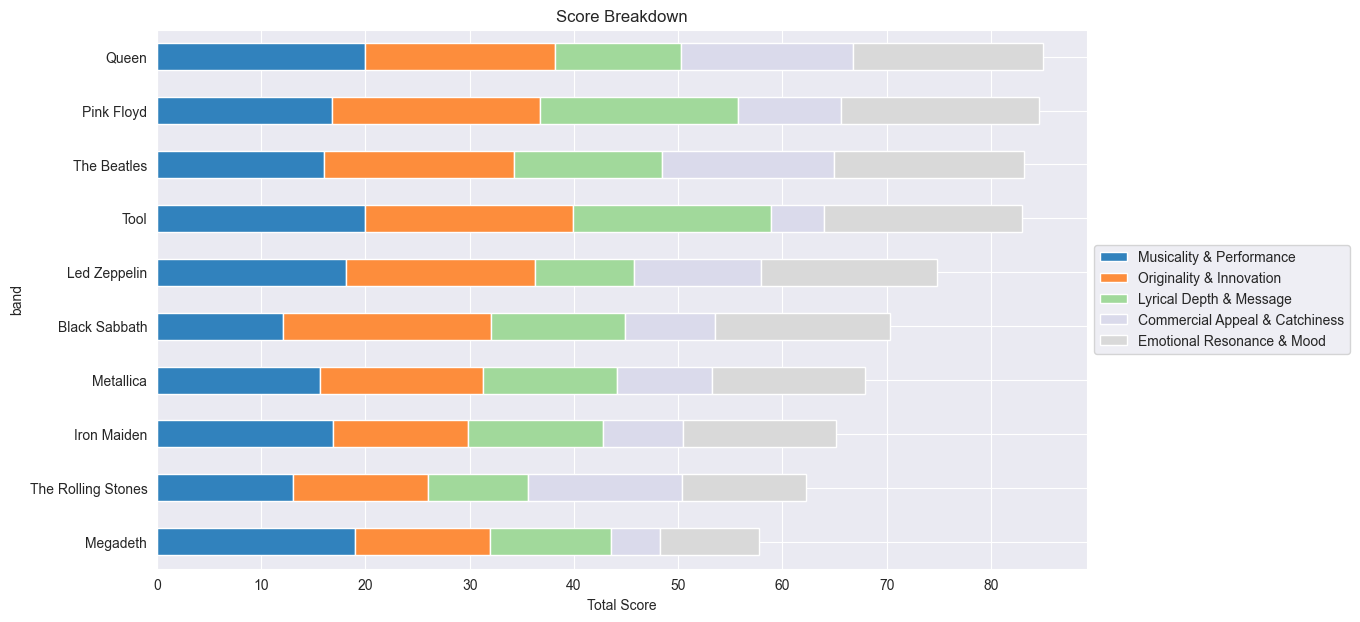

In [18]:
final_scores.plot(kind='barh', stacked=True, figsize=(12, 7), colormap='tab20c')
plt.title("Score Breakdown")
plt.xlabel("Total Score")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Radar Chart

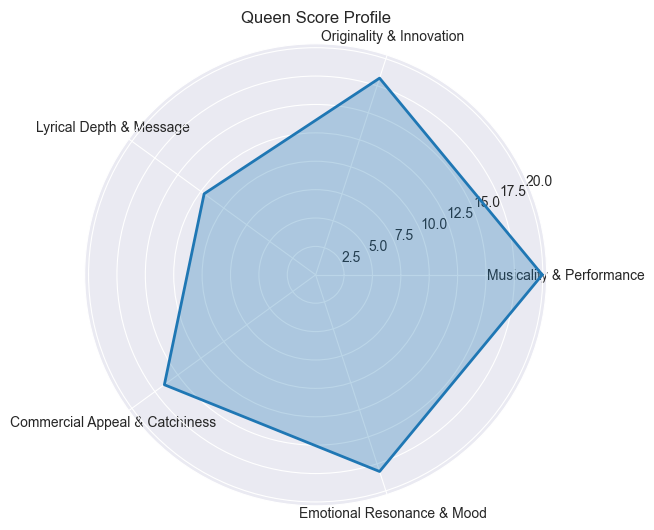

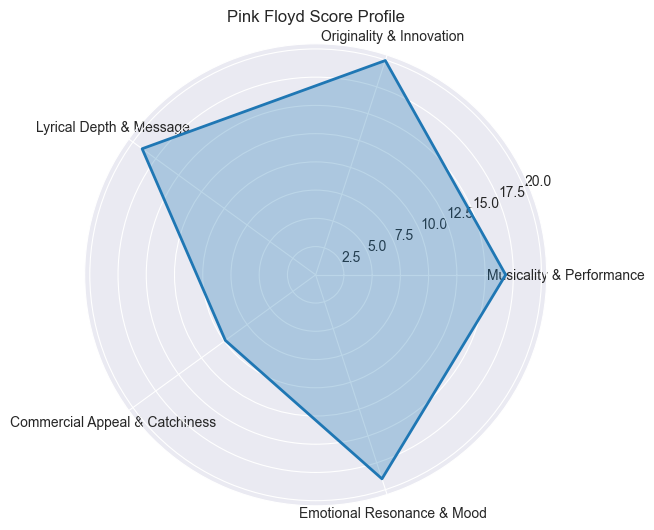

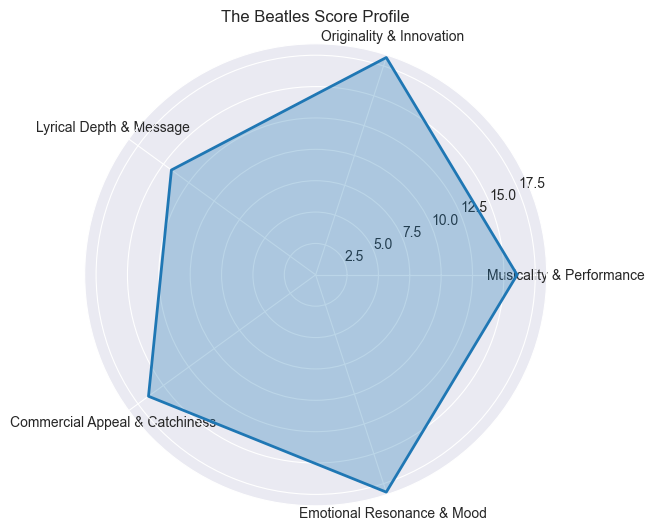

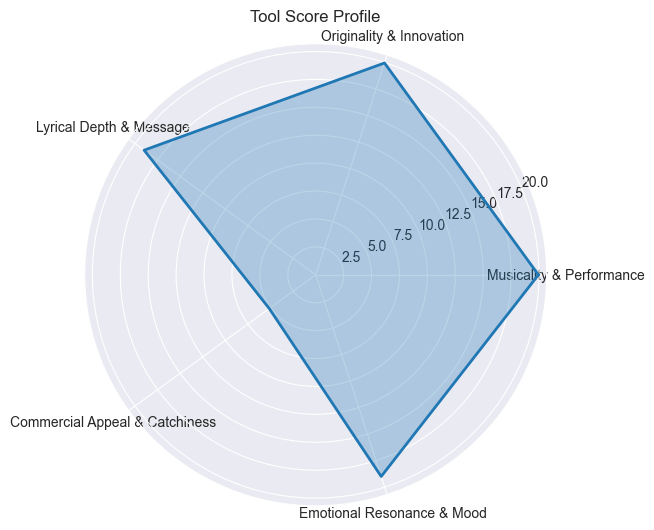

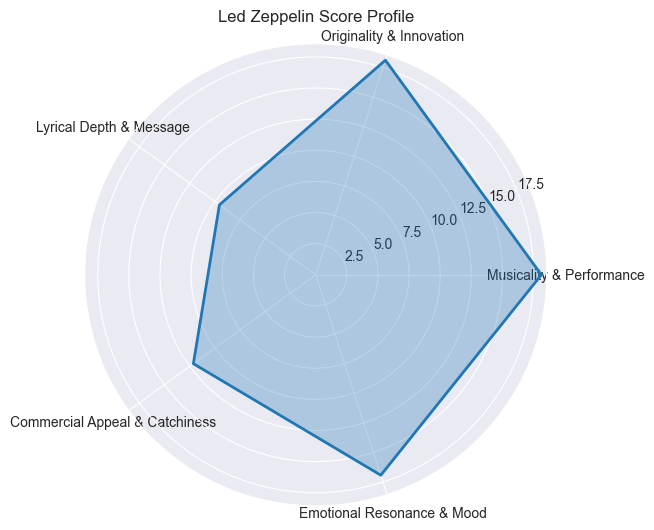

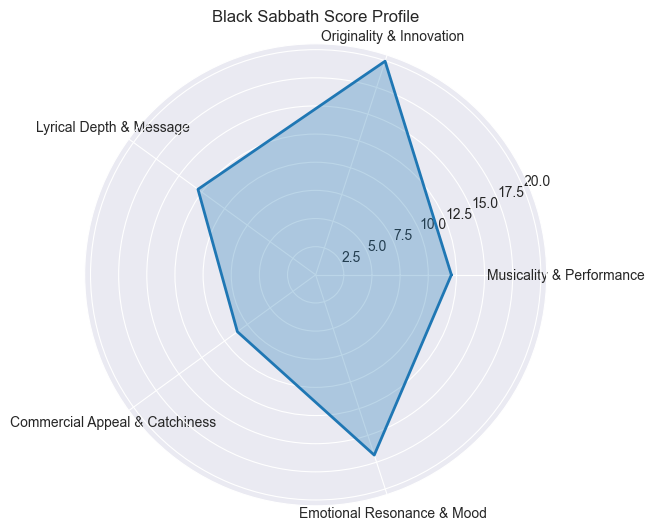

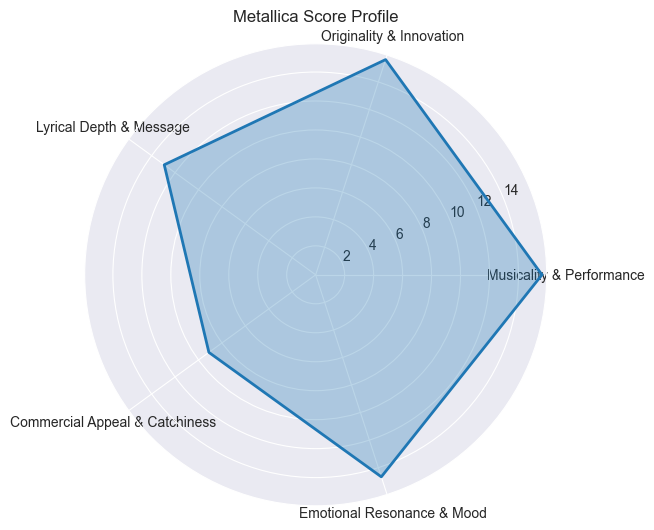

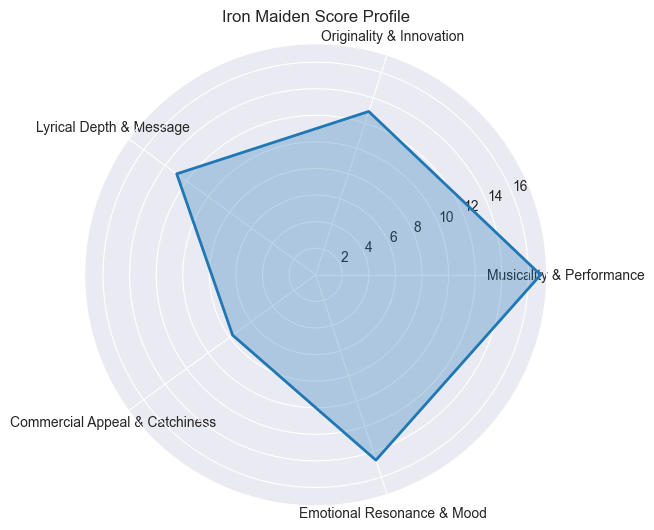

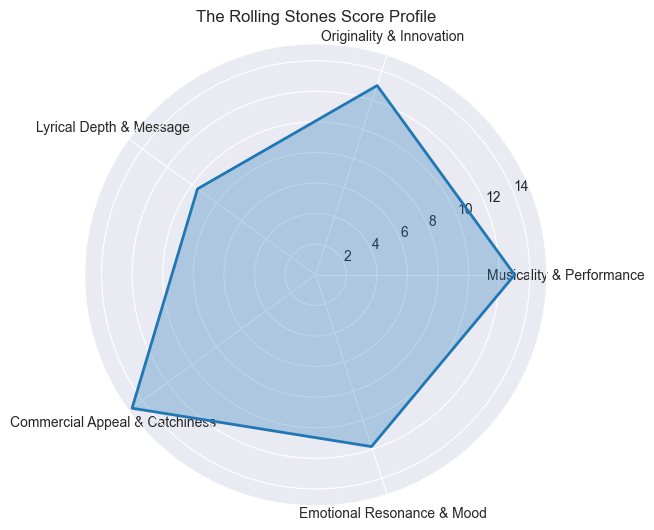

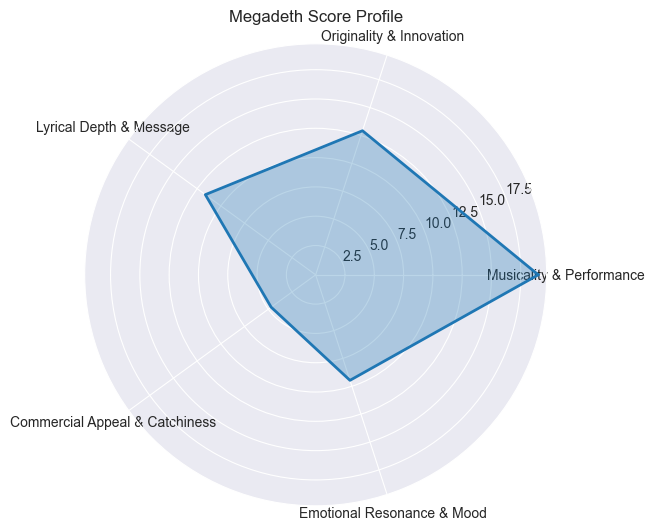

In [19]:
items = final_scores.mean(axis=1).sort_values(ascending=False).index

for item in items:
    values = final_scores.loc[item, criteria_keys].values.flatten().tolist()
    values += values[:1]

    angles = np.linspace(0, 2 * np.pi, len(criteria_keys), endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, linewidth=2, label=item)
    ax.fill(angles, values, alpha=0.3)
    ax.set_thetagrids(np.degrees(angles[:-1]), criteria_keys)
    ax.set_title(f"{item} Score Profile")
    plt.show()

## Heatmap of Criteria Correlation

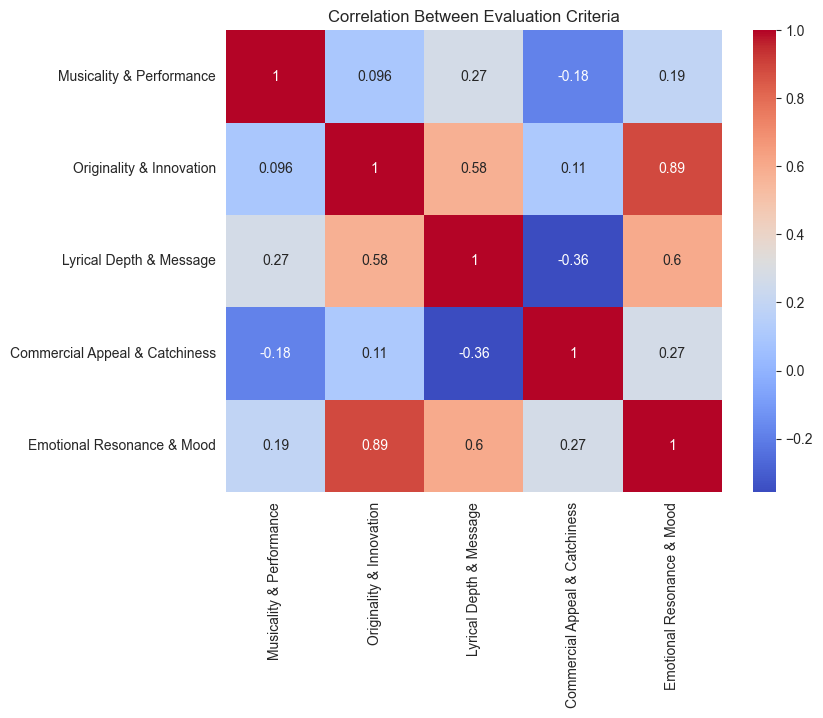

In [20]:
plt.figure(figsize=(8, 6))
sns.heatmap(final_scores[criteria_keys].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Evaluation Criteria")
plt.show()

## Heatmap of individual rankings

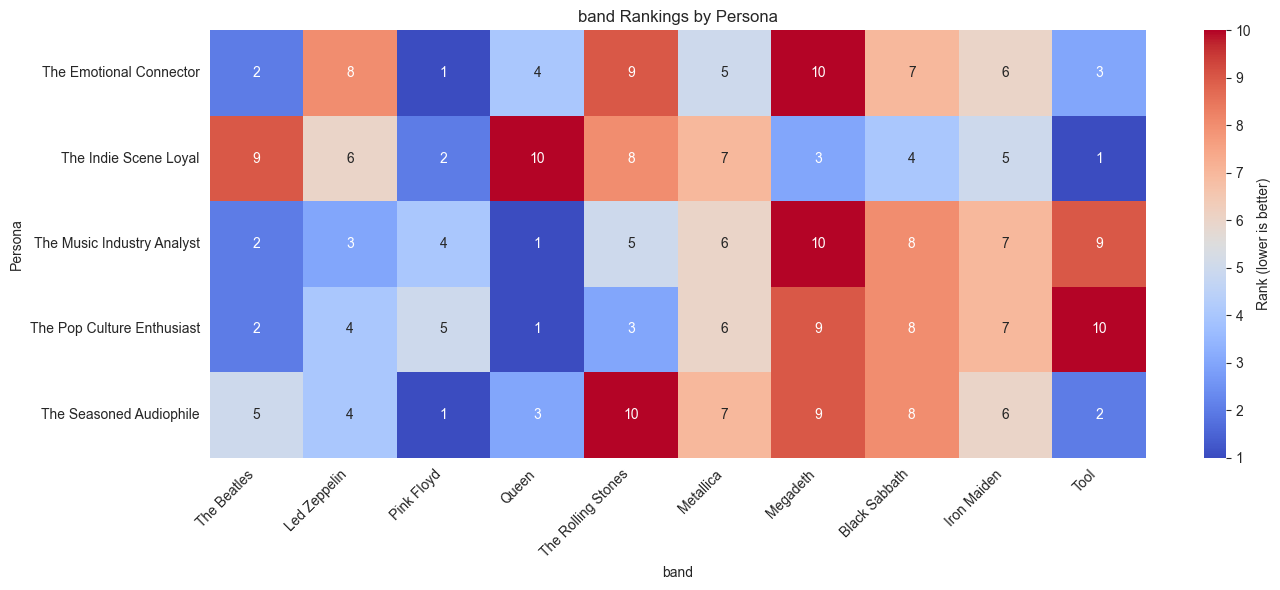

In [21]:
rank_matrix = []
band_names = weighted_votes[0]['df'][EVALUATION_SUBJECT].tolist()
for weighted_vote in weighted_votes:
    rank_row = dict(zip(weighted_vote['df'][EVALUATION_SUBJECT], list(weighted_vote['df']['Rank'])))
    rank_matrix.append(rank_row)

rank_df = pd.DataFrame(rank_matrix, index=[i['persona'] for i in weighted_votes], columns=band_names)
plt.figure(figsize=(14, 6))
sns.heatmap(rank_df, cmap="coolwarm", annot=True, fmt="d", cbar_kws={"label": "Rank (lower is better)"})
plt.title(f"{EVALUATION_SUBJECT} Rankings by Persona")
plt.xlabel(EVALUATION_SUBJECT)
plt.ylabel("Persona")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Statistics

## Summary on rankings

In [22]:
item_ranks = {item: [] for item in ITEMS}
for vote in weighted_votes:
    for item, rank in zip(vote['df'][EVALUATION_SUBJECT], vote['df']['Rank']):
        item_ranks[item].append(rank)

stats = {
    item: {
        "mean_rank": np.mean(ranks),
        "std_dev": np.std(ranks),
        "min_rank": min(ranks),
        "max_rank": max(ranks)
    }
    for item, ranks in item_ranks.items()
}

# change this value to sort by a different statistic ⬇️. This currently shows the diversity of opinions.
rank_stats_df = pd.DataFrame(stats).T.sort_values("std_dev", ascending=False)

rank_stats_df


,mean_rank,std_dev,min_rank,max_rank
Tool,5.0,3.741657,1.0,10.0
Queen,3.8,3.310589,1.0,10.0
The Beatles,4.0,2.756810,2.0,9.0
Megadeth,8.2,2.638181,3.0,10.0
The Rolling Stones,7.0,2.607681,3.0,10.0
Led Zeppelin,5.0,1.788854,3.0,8.0
Pink Floyd,2.6,1.624808,1.0,5.0
Black Sabbath,7.0,1.549193,4.0,8.0
Metallica,6.2,0.748331,5.0,7.0
Iron Maiden,6.2,0.748331,5.0,7.0


## Summary on scores

In [23]:
item_scores = {f'{item}: {criteria}': [] for item in ITEMS for criteria in criteria_keys}
for vote in weighted_votes:
    for criteria in criteria_keys:
        for item, score in zip(vote['df'][EVALUATION_SUBJECT], vote['df'][criteria]):
            item_scores[f'{item}: {criteria}'].append(score)

stats = {
    item: {
        "mean_score": np.mean(ranks),
        "std_dev": np.std(ranks),
        "min_score": min(ranks),
        "max_score": max(ranks)
    }
    for item, ranks in item_scores.items()
}

# change this value to sort by a different statistic ⬇️. This currently shows the diversity of opinions.
score_stats_df = pd.DataFrame(stats).T.sort_values("std_dev", ascending=False)

score_stats_df

,mean_score,std_dev,min_score,max_score
Tool: Commercial Appeal & Catchiness,1.027591,1.568917,0.000000,4.154847
The Beatles: Commercial Appeal & Catchiness,3.293847,1.316967,0.673294,4.181477
Queen: Commercial Appeal & Catchiness,3.293847,1.316967,0.673294,4.181477
Megadeth: Lyrical Depth & Message,2.327231,1.015250,1.307999,4.154847
The Rolling Stones: Commercial Appeal & Catchiness,2.968068,0.931109,1.543682,4.181477
Megadeth: Commercial Appeal & Catchiness,0.939286,0.828126,0.288718,2.414070
Megadeth: Emotional Resonance & Mood,1.893303,0.744508,1.299249,3.284459
Black Sabbath: Emotional Resonance & Mood,3.367020,0.730353,2.265825,4.154847
The Beatles: Lyrical Depth & Message,2.842221,0.672558,2.030550,3.944336
Metallica: Commercial Appeal & Catchiness,1.822485,0.669341,0.673294,2.598499
